In [8]:
import os
import sys
os.chdir(os.path.dirname('../'))
from plt_stock_bs import get_stock_df

c:\Users\84066\Documents\trade_tools\common\smooth_tool.py:206: RuntimeWarning: divide by zero encountered in log
  lmin, lmax = fn(bt.min()), fn(bt.max())
c:\Users\84066\Documents\trade_tools\common\smooth_tool.py:207: RuntimeWarning: divide by zero encountered in log
  val = (fn(bt.iloc[-1])-lmin)/(lmax-lmin)
c:\Users\84066\Documents\trade_tools\common\smooth_tool.py:207: RuntimeWarning: invalid value encountered in double_scalars
  val = (fn(bt.iloc[-1])-lmin)/(lmax-lmin)


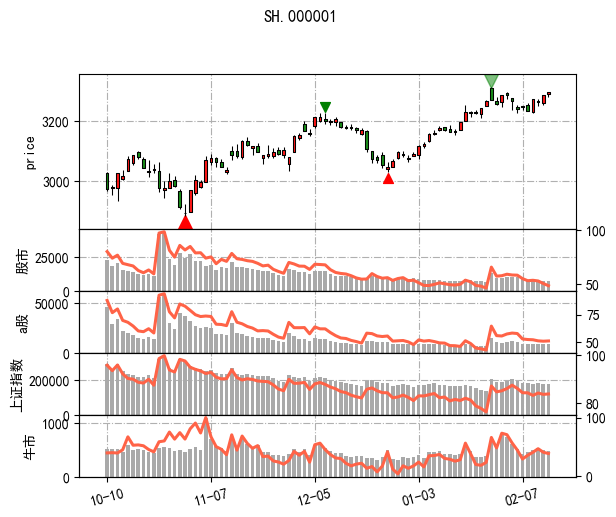

In [11]:
get_stock_df('000001',('股市','a股','上证指数','牛市'),'2022-10-10','2023-02-14')

In [199]:
import matplotlib.pyplot as plt
import akshare as ak
import pandas as pd
import numpy as np
import mplfinance as mpf
import os, sys
sys.path.append('../common/smooth_tool.py')
import smooth_tool

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

idx_lst = '000001'

mark_col = mpf.make_marketcolors(
    up="red",  # 上涨K线的颜色
    down="green",  # 下跌K线的颜色
    edge="black",  # 蜡烛图箱体的颜色
    volume="inherit",  # 成交量柱子的颜色
    wick="black"  # 蜡烛图影线的颜色
)

stl = mpf.make_mpf_style(
    gridaxis='both',
    gridstyle='-.',
    y_on_right=False,
    marketcolors=mark_col,
    rc={'font.family': 'SimHei', 'axes.unicode_minus': 'False'}
    )

In [226]:
df = ak.index_zh_a_hist(idx_lst,start_date='20170201',end_date='20230501')
df.set_index('日期',inplace=True)
df.index.name = 'date'
bsearch = pd.read_csv('../data_save/bsearch_day.csv',index_col=0)
bsearch = bsearch[bsearch['keyword']=='股市'][['index']]
# bsearch = smooth_tool.min_max_dist_pd(bsearch, windows=60, id_name='index')
df = pd.concat([df,bsearch],axis=1,join='inner')
df.rename({'开盘':'Open','收盘':'Close','最高':'High','最低':'Low',
           'index':'Volume', '成交额':'amount'},
           axis=1,inplace=True)
df.index = pd.to_datetime(df.index)

In [209]:
def mark_up_down(dts,winds=(20,60,200),price='l/h'):
    ''' 添加买卖点 '''
    def parse_price(tb,i,price=price):
        if price.lower()=='l/h':
            if tb.iloc[i]['Low']<=min(tb['Low']):
                return 'B', tb.iloc[i]['Low']-20
            elif tb.iloc[i]['High']>=max(tb['High']):
                return 'S', tb.iloc[i]['High']+20
            return
        elif price.lower()=='c':
            if tb.iloc[i]['Close']<=min(tb['Close']):
                return 'B', tb.iloc[i]['Low']-20
            elif tb.iloc[i]['Close']>=max(tb['Close']):
                return 'S', tb.iloc[i]['High']+20
            return
        elif price.lower() in ('co','oc'):
            nval = tb.iloc[i]['Close']+tb.iloc[i]['Open']
            if nval<=min(tb['Close']+tb['Open']):
                return 'B', tb.iloc[i]['Low']-20
            elif nval>=max(tb['Close']+tb['Open']):
                return 'S', tb.iloc[i]['High']+20
            return
        elif price.lower() in ('c/o','o/c'):
            nval = min(tb.iloc[i]['Close'],tb.iloc[i]['Open'])
            mval = max(tb.iloc[i]['Close'],tb.iloc[i]['Open'])
            if nval<=tb[['Close','Open']].values.min():
                return 'B', tb.iloc[i]['Low']-20
            elif mval>=tb[['Close','Open']].values.max():
                return 'S', tb.iloc[i]['High']+20
            return
        return

    wind_l = list(sorted(winds,reverse=True))
    max_W = max(winds)
    bs_pd = pd.DataFrame(np.zeros((len(dts),len(winds)*4)),index=dts.index,
            columns=['%s_%d' % (n,w) for n in 'BSbs' for w in wind_l])
    bs_pd.loc[:,:] = np.nan
    for w in wind_l:
        for i in range(w,len(df)):
            if i<len(df)-w:
                nval = parse_price(dts.iloc[i-w:i+w+1],w,price)
            else:
                nval = parse_price(dts.iloc[i-w:],w,price)
                if nval: nval = (nval[0].lower(), nval[1])
            if nval and (bs_pd.iloc[i][nval[0]+'_'+str(max_W):nval[0]+'_'+str(w)].isna().all()):
                bs_pd.iloc[i][nval[0]+'_'+str(w)] = nval[1]
    return bs_pd

mmm = mark_up_down(df,price='l/h')

In [210]:
def mark_dic(cl_n):
    cl_sz = {'20':50,'60':100,'200':150}
    p1, pcl = ('^','r') if cl_n[0].lower()=='b' else ('v','g')
    alp = 0.5 if cl_n[0].islower() else 1
    return {'markersize':cl_sz[cl_n[2:]], 'marker': p1, 'color': pcl, 'alpha':alp}

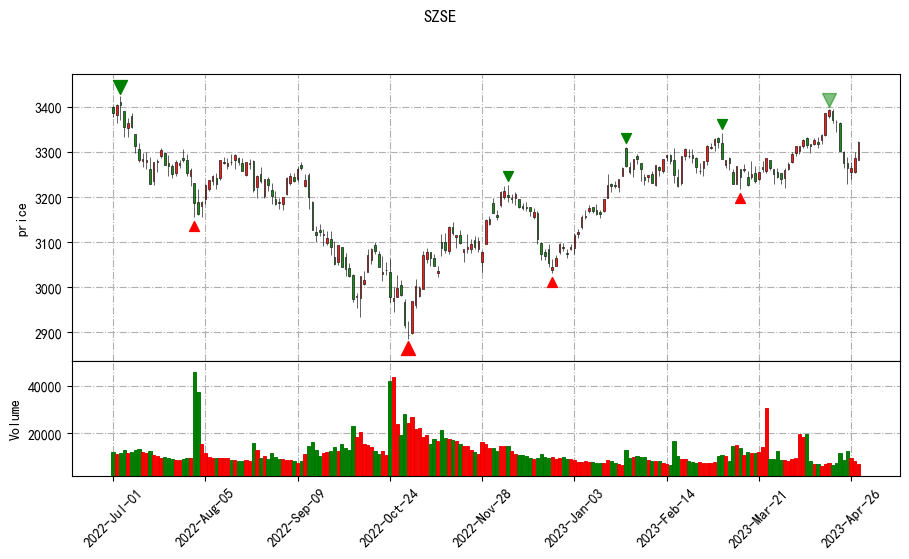

In [227]:
add_plot = [mpf.make_addplot(mmm.loc['2022-07':'2023-04',cl],
                scatter=True, type='scatter',**mark_dic(cl)) for cl in mmm.columns]
add_plot = [a for a in add_plot if not a['data'].isna().all()]
mpf.plot(df.loc['2022-07':'2023-04'],type='candle',style=stl,
         addplot=add_plot,volume=True, ylabel='price',title='SZSE',figratio=(6,3))